## Time-series based analysis of Earthquake Risk Factors

### Part 4: Performing linear regression

Importing the required libraries:

In [1]:
import requests
import json
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score




import pickle

In [2]:
lr = pickle.load(open('../datasets/lr.pkl', 'rb'))

ss = pickle.load(open('../datasets/ss.pkl', 'rb'))



### Part 2.1: Prepping Loma Prieta EQ's:

In [3]:
file_path = "../datasets/" + "eq_parkfield" + "_clean" + ".csv"

df_lp_eq = pd.read_csv(file_path)
df_lp_eq.drop(columns = "Unnamed: 0", inplace = True)

df_lp_eq["time"] = pd.to_datetime(df_lp_eq["time"])

df_lp_eq.sort_values(by = "time", inplace=True)


df_lp_eq.reset_index(drop = True, inplace=True)
df_lp_eq.drop(columns = ["index", "place", "status", "tsunami", "net", "nst", "type"], inplace=True)

df_lp_eq.head()

,time,mag,sig,dmin,rms,gap,magType,longitude,latitude,depth
0,2004-09-20 15:59:25.390,2.38,87,0.02523,0.0600,35.00,md,-121.548667,36.825333,5.964
1,2004-09-20 15:59:35.318,1.60,39,0.07000,0.1135,75.17,ml,-118.653400,38.024800,7.000
2,2004-09-20 16:01:44.638,1.10,19,0.03600,0.1353,101.52,ml,-118.691400,37.999300,2.800
3,2004-09-20 16:02:06.359,1.00,15,0.05000,0.1561,94.73,mb,-118.670900,38.004100,3.600
4,2004-09-20 16:05:18.108,1.20,22,0.04200,0.0586,96.83,mb,-118.686100,38.003400,5.400


In [4]:
df_lp_eq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       2000 non-null   datetime64[ns]
 1   mag        2000 non-null   float64       
 2   sig        2000 non-null   int64         
 3   dmin       1999 non-null   float64       
 4   rms        2000 non-null   float64       
 5   gap        2000 non-null   float64       
 6   magType    2000 non-null   object        
 7   longitude  2000 non-null   float64       
 8   latitude   2000 non-null   float64       
 9   depth      2000 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(1)
memory usage: 156.4+ KB


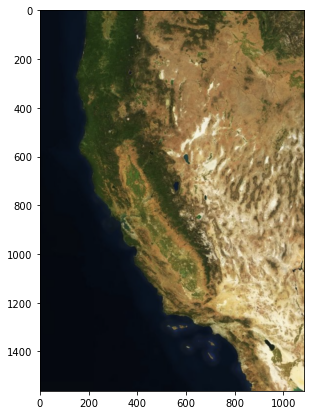

In [5]:
plt.figure(figsize = (10,7))
im = plt.imread("../assets/Satellite_map_region.png")
implot = plt.imshow(im)

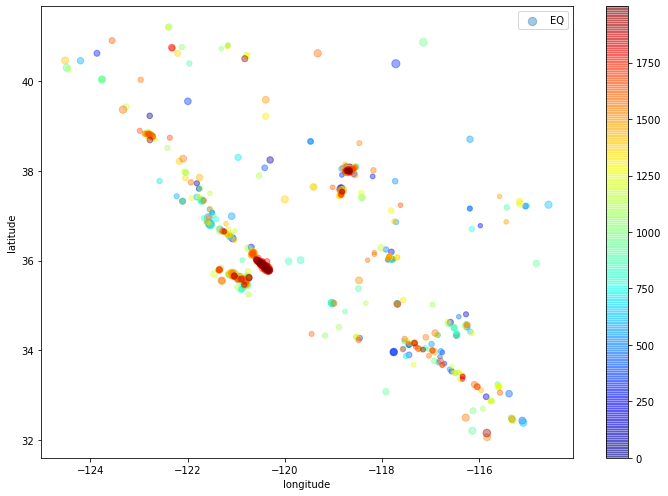

In [6]:
ax = plt.gca()


df_lp_eq.plot(kind="scatter", x="longitude", y="latitude",
    s=df_lp_eq['mag']/0.05, label="EQ",
    c=df_lp_eq.index, cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(10,7), ax = ax
)
plt.legend()

plt.tight_layout()

## Finding the main failure time:

In [7]:
# Source: https://stackoverflow.com/questions/43601868/converting-an-array-datatime-datetime-to-float
import datetime as dt

epoch = dt.datetime(1970, 1, 1)

time = []
for t in [(d - epoch).total_seconds() for d in df_lp_eq["time"]]:
    time.append(float('%.6f' % t))
    
(float(time[0]))

df_lp_eq["time_seconds"] = time

failure_event = df_lp_eq[df_lp_eq["mag"] == df_lp_eq["mag"].max()]

df_lp_eq["time_to_failure_sec"] = np.array(df_lp_eq["time_seconds"]) - np.array(failure_event["time_seconds"])


In [8]:
df_lp_eq.drop(columns=["time", "time_seconds"], inplace=True)


df_lp_eq.head()

,mag,sig,dmin,rms,gap,magType,longitude,latitude,depth,time_to_failure_sec
0,2.38,87,0.02523,0.0600,35.00,md,-121.548667,36.825333,5.964,-695758.860
1,1.60,39,0.07000,0.1135,75.17,ml,-118.653400,38.024800,7.000,-695748.932
2,1.10,19,0.03600,0.1353,101.52,ml,-118.691400,37.999300,2.800,-695619.612
3,1.00,15,0.05000,0.1561,94.73,mb,-118.670900,38.004100,3.600,-695597.891
4,1.20,22,0.04200,0.0586,96.83,mb,-118.686100,38.003400,5.400,-695406.142


Checking if failure is correctly zero:

In [9]:
failure_event = df_lp_eq[df_lp_eq["mag"] == df_lp_eq["mag"].max()]

failure_event

,mag,sig,dmin,rms,gap,magType,longitude,latitude,depth,time_to_failure_sec
1694,5.97,1280,0.01622,0.04,26.0,mw,-120.366,35.818167,8.136,0.0


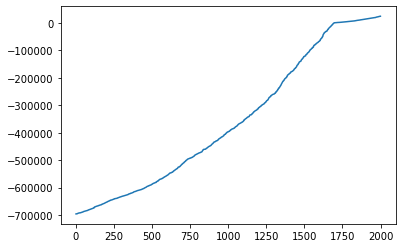

In [10]:
plt.plot(df_lp_eq["time_to_failure_sec"])

# 3D clustering with long-lat-depth

In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.datasets import load_iris, load_wine
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

Standardizing the data:

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


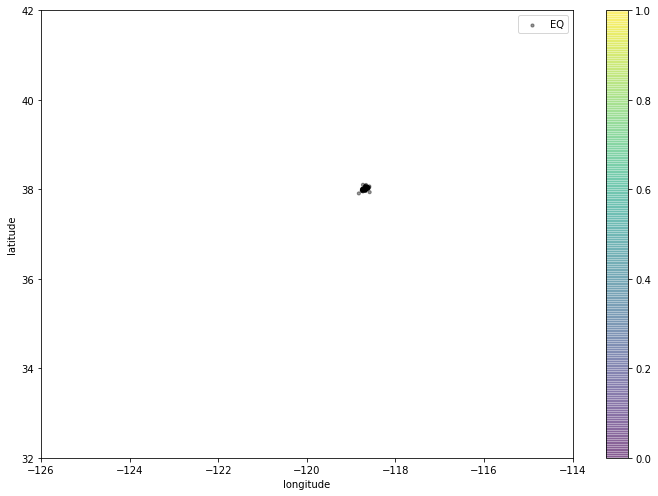

In [12]:
#Creating the df for creating the clusters

df_lp_eq_cut = df_lp_eq

df_lp_eq_cut_cut = df_lp_eq_cut.iloc[0:700,:]

df = df_lp_eq_cut_cut[["longitude", "latitude", "depth"]]

ss = StandardScaler()

X_scaled = ss.fit_transform(df)

dbscan = DBSCAN(eps = 0.2, min_samples=5)

dbscan.fit(X_scaled);

df['cluster'] = dbscan.labels_


df_2 = df_lp_eq.copy()

df_2["cluster"] = df["cluster"]


# Getting the top cluster
Top_clusters = df_2.groupby("cluster")["cluster"].count().sort_values(ascending = False)[:3].index


# Plotting the top cluster
if (Top_clusters[0] < 0):
    cluster_mask = Top_clusters[1]
else:
    cluster_mask = Top_clusters[0]
    

ax = plt.gca()
df_selected = df[df["cluster"] == cluster_mask]

df_selected.plot(kind="scatter", x="longitude", y="latitude",
    s=[10] * len(df_selected),
    label="EQ",
    c="black",
    cmap=plt.get_cmap("jet"),
    colorbar=True, 
    alpha=0.4, 
    figsize=(10,7), ax = ax,
    xlim=(-126, -114),
    ylim=(32, 42)
)

plt.legend()

plt.tight_layout()

plt.savefig("../plots/cluster_example.png")


In [13]:
df_2.groupby("cluster")["cluster"].count().sort_values(ascending = False)

cluster
 0.0    547
-1.0    116
 1.0     11
 2.0     10
 4.0      6
 5.0      5
 3.0      5
Name: cluster, dtype: int64

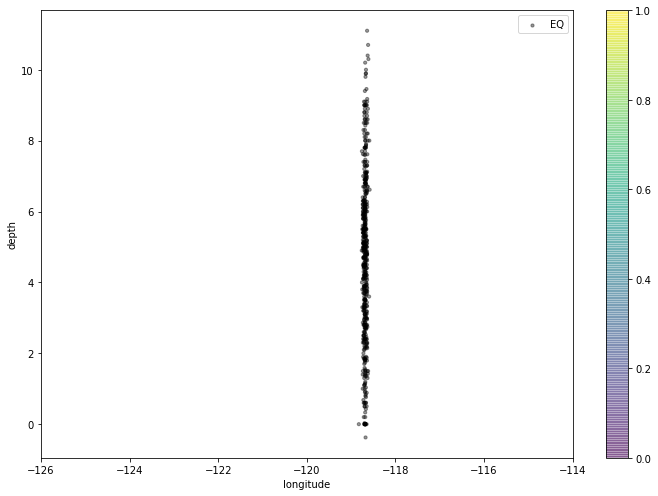

In [14]:
ax = plt.gca()
df_selected = df[df["cluster"] == cluster_mask]

df_selected.plot(kind="scatter", x="longitude", y="depth",
    s=[10] * len(df_selected),
    label="EQ",
    c="black",
    cmap=plt.get_cmap("jet"),
    colorbar=True, 
    alpha=0.4, 
    figsize=(10,7), ax = ax,
    xlim=(-126, -114),
)

plt.legend()

plt.tight_layout()

plt.savefig("../plots/cluster_example_depth.png")



# Moving clusters design

In [15]:
data = {"mag_mean": 0, "density": 0, "long_cent": 0, "long_std": 0,
                  "lat_cent": 0, "lat_std": 0, "dept_cent": 0, "dept_std": 0, "time_to_failure": 0}

cluster_df = pd.DataFrame(data, index=[0])



df_lp_eq_cut = df_lp_eq


for i in range(700, len(df_lp_eq_cut), 20):

    df_lp_eq_cut_cut = df_lp_eq_cut.iloc[:i,:]

    df = df_lp_eq_cut_cut[["longitude", "latitude", "depth", "mag", "time_to_failure_sec"]]

    ss = StandardScaler()

    X_scaled = ss.fit_transform(df[["longitude", "latitude", "depth"]])

    dbscan = DBSCAN(eps = 0.2, min_samples=5)

    dbscan.fit(X_scaled);

    df['cluster'] = dbscan.labels_


    df_2 = df_lp_eq.copy()

    df_2["cluster"] = df["cluster"]


    # Getting the top cluster
    Top_clusters = df_2.groupby("cluster")["cluster"].count().sort_values(ascending = False)[:3].index


    # Plotting the top cluster
    if (Top_clusters[0] < 0):
        cluster_mask = Top_clusters[1]
    else:
        cluster_mask = Top_clusters[0]

    df_selected = df[df["cluster"] == cluster_mask]   




    max_lat = df_selected["latitude"].max()
    min_lat = df_selected["latitude"].min()
    max_long = df_selected["longitude"].max()
    min_long = df_selected["longitude"].min()

    area = (max_lat - min_lat)*(max_long - min_long)
    cluster_density = area / len(df_selected)

    cluster_mag_mean = df_selected["mag"].mean()

    cluster_long_cent = df_selected["longitude"].mean()

    cluster_long_std = df_selected["longitude"].std()

    cluster_lat_cent = df_selected["latitude"].mean()

    cluster_lat_std = df_selected["latitude"].std()

    cluster_dept_cent = df_selected["depth"].mean()

    cluster_dept_std = df_selected["depth"].std()


    cluster_time_to_failure = df_selected["time_to_failure_sec"].iloc[-1]

    rows = [cluster_mag_mean, cluster_density, cluster_long_cent, cluster_long_std,
                      cluster_lat_cent, cluster_lat_std, cluster_dept_cent, cluster_dept_std, cluster_time_to_failure
                      ]


    cluster_df.loc[len(cluster_df)] = rows

cluster_df.drop(cluster_df.index[0], inplace=True)



cluster_df["long_mov"] = cluster_df["long_cent"].diff()
cluster_df["lat_mov"] = cluster_df["long_cent"].diff()

cluster_df.dropna(inplace = True)


cluster_df.reset_index(inplace=True)

cluster_df.drop(columns = "index", inplace=True)





/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [16]:
cluster_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mag_mean         64 non-null     float64
 1   density          64 non-null     float64
 2   long_cent        64 non-null     float64
 3   long_std         64 non-null     float64
 4   lat_cent         64 non-null     float64
 5   lat_std          64 non-null     float64
 6   dept_cent        64 non-null     float64
 7   dept_std         64 non-null     float64
 8   time_to_failure  64 non-null     float64
 9   long_mov         64 non-null     float64
 10  lat_mov          64 non-null     float64
dtypes: float64(11)
memory usage: 5.6 KB


In [17]:
cluster_df.head(20)

,mag_mean,density,long_cent,long_std,lat_cent,lat_std,dept_cent,dept_std,time_to_failure,long_mov,lat_mov
0,1.482531,0.000083,-118.684542,0.029678,38.008197,0.017603,4.717807,2.365567,-503169.320,0.000245,0.000245
1,1.483649,0.000081,-118.684565,0.029441,38.008130,0.017456,4.726396,2.356802,-494919.200,-0.000023,-0.000023
2,1.482466,0.000080,-118.684475,0.029427,38.008191,0.017367,4.753456,2.361047,-490265.730,0.000090,0.000090
3,1.480890,0.000078,-118.684147,0.029568,38.008178,0.017369,4.756715,2.358625,-482337.008,0.000328,0.000328
4,1.481926,0.000076,-118.684305,0.029588,38.008132,0.017253,4.752891,2.362542,-476387.390,-0.000157,-0.000157
5,1.482449,0.000074,-118.684442,0.029708,38.008128,0.017237,4.748698,2.359058,-471302.810,-0.000137,-0.000137
6,1.481755,0.000088,-118.683748,0.030806,38.008473,0.017874,4.743123,2.369993,-461182.856,0.000694,0.000694
7,1.485275,0.000087,-118.683712,0.031099,38.008491,0.017952,4.725284,2.371106,-456765.910,0.000036,0.000036
8,1.485712,0.000085,-118.683682,0.031112,38.008479,0.017914,4.746328,2.363435,-448391.215,0.000030,0.000030
9,1.482588,0.000084,-118.683695,0.031064,38.008389,0.017833,4.749376,2.351954,-439356.640,-0.000013,-0.000013


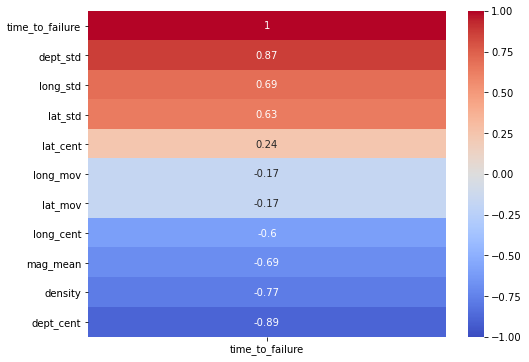

In [18]:
import seaborn as sns


df_corr = cluster_df.corr()

#plt.figure(figsize=(6,6))
plt.figure(figsize=(8,6))
sns.heatmap(df_corr[['time_to_failure']].sort_values(by=['time_to_failure'],ascending=False),
            vmin=-1,
            cmap='coolwarm',
            annot=True);
plt.savefig("../plots/EDA_corr_plots.png")

In [19]:

# Step 1: Assemble our X and y variables

# We need an X matrix that is n-by-p (in this case, p = 1)
X = cluster_df.drop(columns=["time_to_failure", "long_cent", "lat_cent"])


ss = StandardScaler()

X_scaled = ss.fit_transform(X)


# We need a y vector that is length n
y = cluster_df["time_to_failure"]

lr = LinearRegression()

y_pred = lr.fit(X_scaled, y)


lr.score(X_scaled, y)

0.9850113793162095

In [20]:
coef_df = pd.DataFrame({'features': list(X.columns), 
              'coef' : list(lr.coef_)})
coef_df = coef_df.set_index('features')
coef_df = coef_df.sort_values('coef', ascending = False)
coef_df.head(10)

,coef
features,
lat_std,79257.910915
dept_std,48610.832305
long_std,2782.414478
dept_cent,-3120.227506
lat_mov,-4810.025824
long_mov,-4810.025824
mag_mean,-29434.562385
density,-74622.340815


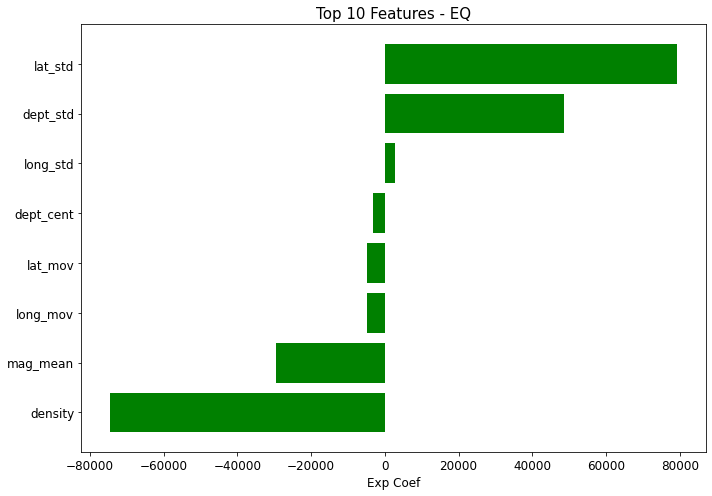

In [21]:
weights = coef_df['coef'].head(10).sort_values()
labels = weights.index

plt.figure(figsize=(10,7))
plt.barh(labels, weights, color = 'green')
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel('Exp Coef', fontsize=12)
plt.title(f'Top 10 Features - EQ', fontsize=15)
plt.tight_layout()



In [23]:
print("Hello World!")

Hello World!
